In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from joblib import dump, load


/pool0/home/sanjay.r/anaconda3/envs/sergio_rotation/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Load node information

spoke = np.load('../../psev_repo/PSEV_matrix')
sep = np.load('../../psev_repo/PSEV_SEP_map')
spoke_node = np.load('../../psev_repo/PSEV_SPOKE_node_map')

spoke = pd.DataFrame(spoke, columns=spoke_node)
spoke.index = sep
spoke.index = spoke.index.map(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
spoke.columns = spoke.columns.map(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

node_type = np.load('../../psev_repo/node_type_list.npy')
node_type = [x.decode('utf-8') if isinstance(x, bytes) else x for x in node_type]
node_type = pd.DataFrame({
    'node': spoke.columns,
    'type': node_type
})

unique_node_types = node_type['type'].unique()

In [3]:
#Translating conditions
# disease_annotation = pd.read_csv('../../psev_repo/omop_sep_map/filtered_omop_conditions_to_spoke_extended_2.tsv', sep = '\t')

disease_annotation = pd.read_csv('../../gbellucci/spoke_linkers/omop2spoke_combined.tsv', sep = '\t')
disease_annotation.rename(columns={'OMOP': 'condition_concept_id'}, inplace=True)
disease_annotation.rename(columns={'SPOKE': 'spoke_concept_id'}, inplace=True)

spoke_to_omop_dict = dict(zip(disease_annotation['spoke_concept_id'], disease_annotation['condition_concept_id']))


#Translating Drugs
drug_annotation = pd.read_csv('../../psev_repo/omop_sep_map/filtered_omop_drug_exposure_to_spoke_extended.tsv', sep = '\t')
drug_annotation.rename(columns={'OMOP': 'condition_concept_id'}, inplace=True)
drug_annotation.rename(columns={'SPOKE': 'spoke_concept_id'}, inplace=True)

spoke_to_omop_dict.update(dict(zip(drug_annotation['spoke_concept_id'], drug_annotation['condition_concept_id'])))


#Translating measurements
lab_annotation = pd.read_csv('../../psev_repo/omop_sep_map/filtered_omop_measurement_to_spoke_extended.tsv', sep = '\t')
lab_annotation.rename(columns={'OMOP': 'condition_concept_id'}, inplace=True)
lab_annotation.rename(columns={'SPOKE': 'spoke_concept_id'}, inplace=True)

spoke_to_omop_dict.update(dict(zip(lab_annotation['spoke_concept_id'], lab_annotation['condition_concept_id'])))


# Assemble the Tables in Pandas

In [5]:
#First load the general top 30% PSEVs

pat_ids = np.load('data/psevs/person_id_index.npy')
columns = np.load('data/psevs/filtered_patient_psevs_columns.npy', allow_pickle=True)
psevs = np.load('data/psevs/filtered_patient_psevs.npy')

full_bio_cohort = pd.read_feather('data/opioid_cohort_details.feather')
label_dict = dict(zip(full_bio_cohort["person_id"], full_bio_cohort["dependent"]))

#Now load the node specific ones

# Initialize empty arrays for columns and psevs
nt_columns = None
nt_psevs = None

for nt in unique_node_types:
    ind_nt_psevs = np.load(f'data/nt_psevs/filtered_patient_psevs_{nt}.npy')
    ind_nt_columns = np.load(f'data/nt_psevs/filtered_patient_psevs_columns_{nt}.npy', allow_pickle=True)

    # Concatenate columns and psevs
    if nt_columns is None:
        nt_columns = ind_nt_columns
    else:
        nt_columns = np.concatenate((nt_columns, ind_nt_columns))  # Add new columns

    if nt_psevs is None:
        nt_psevs = ind_nt_psevs
    else:
        nt_psevs = np.hstack((nt_psevs, ind_nt_psevs))  # Add new data horizontally

In [6]:
psevs.shape

(17797, 116484)

In [7]:
columns.shape

(116484,)

In [8]:
nt_columns.shape

(116788,)

In [9]:
#Format tables for RF
Y = np.array([label_dict[pid] for pid in pat_ids if pid in label_dict])
X = psevs
nt_X = nt_psevs

# Run PCA/UMAP to see how well linear/non-linear dimension-reduction captures variability

In [10]:
def plot_pca(vectors, labels):
    # Step 1: Perform PCA
    pca = PCA(n_components=2)  # Reduce to 2 dimensions
    pca_result = pca.fit_transform(vectors)

    # Step 2: Separate the PCA components by labels
    pca_true = pca_result[labels]  # Points with label True
    pca_false = pca_result[~labels]  # Points with label False

    # Step 3: Plot the results
    plt.figure(figsize=(10, 8))
    plt.scatter(pca_true[:, 0], pca_true[:, 1], c='blue', label='True', alpha=0.7)
    plt.scatter(pca_false[:, 0], pca_false[:, 1], c='red', label='False', alpha=0.7)

    # Add labels and legend
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('PCA Visualization')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_umap(vectors, labels):
    # Step 1: Perform UMAP
    umap_reducer = umap.UMAP(n_components=2, random_state=42)
    umap_result = umap_reducer.fit_transform(vectors)

    # Step 2: Separate the UMAP components by labels
    umap_true = umap_result[labels]  # Points with label True
    umap_false = umap_result[~labels]  # Points with label False

    # Step 3: Plot the results
    plt.figure(figsize=(10, 8))
    plt.scatter(umap_true[:, 0], umap_true[:, 1], c='blue', label='True', alpha=0.7)
    plt.scatter(umap_false[:, 0], umap_false[:, 1], c='red', label='False', alpha=0.7)

    # Add labels and legend
    plt.xlabel('UMAP Component 1')
    plt.ylabel('UMAP Component 2')
    plt.title('UMAP Visualization')
    plt.legend()
    plt.grid(True)
    plt.show()

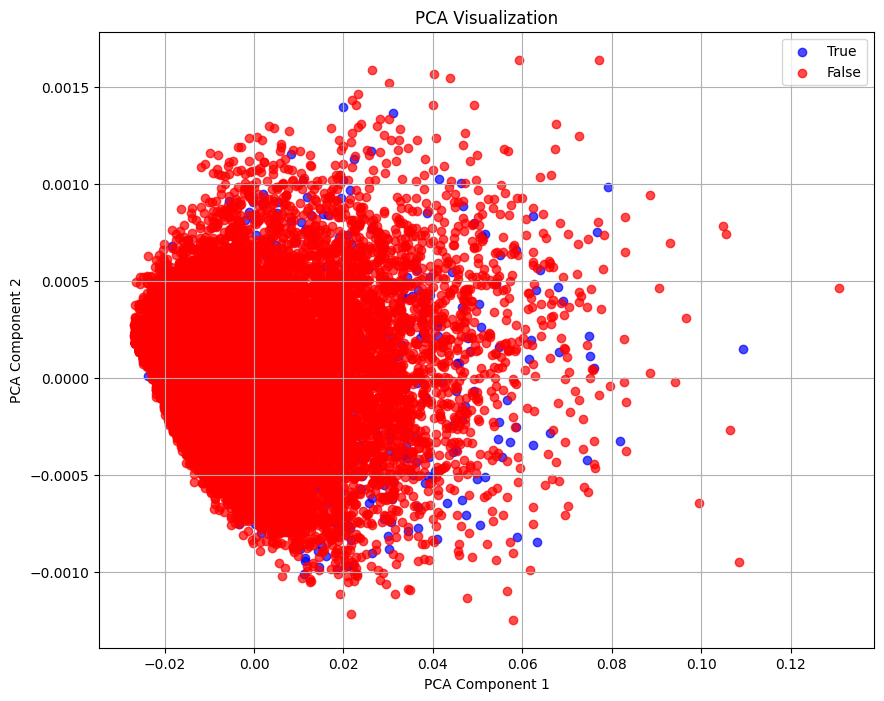

In [11]:
plot_pca(X, Y)

/pool0/home/sanjay.r/anaconda3/envs/sergio_rotation/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


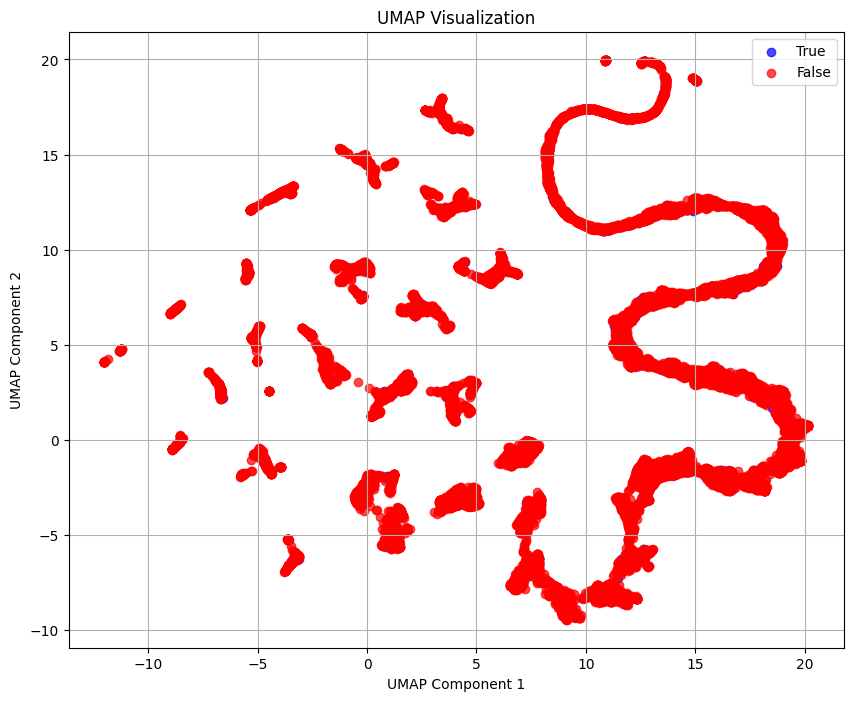

In [12]:
plot_umap(X, Y)

# Train Models

In [ ]:
def runGenericRF(X, Y, name):
    # Split data into training and testing sets (80% train, 20% test)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Initialize the Random Forest classifier
    rf_clf = RandomForestClassifier(n_estimators=100, max_features=int(np.sqrt(X.shape[1])), random_state=42)

    # Train the model on the training data
    rf_clf.fit(X_train, Y_train)

    # Predict on the test data
    Y_pred = rf_clf.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(Y_test, Y_pred)
    print(f"{name} Model accuracy: {accuracy:.2f}")

    dump(rf_clf, f'models/addiction_rf_model_{name}.joblib')

    return accuracy, rf_clf

# TRY LASSO REGRESSION TO DEFEATURIZE THE SET? 

In [ ]:
accuracy_general, model_general = runGenericRF(X, Y, "general")

accuracy_nt, model_nt = runGenericRF(nt_X, Y, "nt")

general Model accuracy: 0.94
nt Model accuracy: 0.94


In [5]:
# Load here
model_general = load('models/addiction_rf_model_general.joblib')
model_nt = load('models/addiction_rf_model_nt.joblib')

In [6]:
feature_importance_df = pd.DataFrame({
        'feature': columns,
        'importance': model_general.feature_importances_
    })
    
feature_importance_df = pd.merge(feature_importance_df, node_type, left_on = "feature", right_on = "node").drop("feature", axis = 1).sort_values(by = 'importance', ascending = False)
feature_importance_df['omop'] = feature_importance_df['node'].map(spoke_to_omop_dict)

nt_feature_importance_df = pd.DataFrame({
        'feature': nt_columns,
        'importance': model_nt.feature_importances_
    })
    
nt_feature_importance_df = pd.merge(nt_feature_importance_df, node_type, left_on = "feature", right_on = "node").drop("feature", axis = 1).sort_values(by = 'importance', ascending = False)
nt_feature_importance_df['omop'] = nt_feature_importance_df['node'].map(spoke_to_omop_dict)

In [7]:
feature_importance_df.head()

,importance,node,type,omop
114724,0.000663,Q9GZZ6,Protein,NaN
60307,0.000463,CHEMBL267841,Compound,NaN
74229,0.000354,CHEMBL3544968,Compound,NaN
76020,0.000321,CHEMBL368591,Compound,NaN
7170,0.000316,CHEMBL1200703,Compound,NaN


In [13]:
nt_feature_importance_df.groupby('type').count()

,importance,node,omop
type,,,
Anatomy,3977,3977,18
BiologicalProcess,3947,3947,5
CellularComponent,517,517,3
Compound,86036,86036,29
Disease,2739,2739,2031
Gene,5870,5870,30
MolecularFunction,1021,1021,1
Pathway,729,729,0
PharmacologicClass,524,524,4


In [9]:
feature_importance_df.groupby('type').count()

,importance,node,omop
type,,,
BiologicalProcess,8,8,0
Compound,106858,106858,35
Disease,37,37,15
Gene,40,40,0
PharmacologicClass,140,140,1
Protein,9399,9399,0
Symptom,2,2,0


In [24]:
feature_importance_df.sort_values('importance', ascending = False).head(240).drop('omop', axis = 1)

,importance,node,type
114724,0.000663,Q9GZZ6,Protein
60307,0.000463,CHEMBL267841,Compound
74229,0.000354,CHEMBL3544968,Compound
76020,0.000321,CHEMBL368591,Compound
7170,0.000316,CHEMBL1200703,Compound
...,...,...,...
108902,0.000124,P0CG31,Protein
80540,0.000124,CHEMBL399284,Compound
113245,0.000124,Q8TBB6,Protein
68670,0.000124,CHEMBL3234759,Compound


In [25]:
t240 = feature_importance_df.sort_values('importance', ascending = False).head(240).drop('omop', axis = 1)
nt_t20 = nt_feature_importance_df.groupby('type', group_keys=False).apply(lambda group: group.nlargest(20, 'importance')).drop('omop', axis = 1)

/tmp/ipykernel_21495/1526204141.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nt_t20 = nt_feature_importance_df.groupby('type', group_keys=False).apply(lambda group: group.nlargest(20, 'importance')).drop('omop', axis = 1)


In [27]:
t240.to_csv('features/top_features_general.csv', index = False)
nt_t20.to_csv('features/top_features_nt.csv', index = False)

In [3]:
t240 = pd.read_csv('features/top_features_general.csv')
nt_t20 = pd.read_csv('features/top_features_nt.csv')

In [4]:
t240

,importance,node,type
0,0.000663,Q9GZZ6,Protein
1,0.000463,CHEMBL267841,Compound
2,0.000354,CHEMBL3544968,Compound
3,0.000321,CHEMBL368591,Compound
4,0.000316,CHEMBL1200703,Compound
...,...,...,...
235,0.000124,P0CG31,Protein
236,0.000124,CHEMBL399284,Compound
237,0.000124,Q8TBB6,Protein
238,0.000124,CHEMBL3234759,Compound


In [5]:
nt_t20

,importance,node,type
0,0.000202,UBERON:0005413,Anatomy
1,0.000189,UBERON:4300186,Anatomy
2,0.000188,UBERON:0001536,Anatomy
3,0.000185,UBERON:0013076,Anatomy
4,0.000172,UBERON:0001406,Anatomy
...,...,...,...
235,0.000073,D051474,Symptom
236,0.000071,D058568,Symptom
237,0.000068,D006930,Symptom
238,0.000067,D059390,Symptom


# Load the top 'n' of each node type and visualize the smallest possible network in SPOKE

## Threshold for n based on difference in importance (MS paper w Charlotte)

## Can also show a difference in concept importance between all 3 cohorts